## Train the Classifier - Generate Model Checkpoints

In [10]:
from src.neuralnet import NeuralNetwork
import torch
import torch.nn as nn
import torch.functional as F
import torchvision
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import sklearn.metrics
from time import time
import kagglehub
import os
import patoolib

First, download and extract dataset. Download and extraction may take a few minutes.

In [2]:
path = kagglehub.dataset_download("xainano/handwrittenmathsymbols")

print("Path to dataset files:", path)

# Extract .rar. Note that this requires unrar to be installed
# - sudo apt install unrar
patoolib.extract_archive(path + "/data.rar", outdir=path + "/data/")

INFO patool: Extracting /home/ajl64/.cache/kagglehub/datasets/xainano/handwrittenmathsymbols/versions/2/data.rar ...
INFO patool: running /usr/bin/unrar x -kb -or -- /home/ajl64/.cache/kagglehub/datasets/xainano/handwrittenmathsymbols/versions/2/data.rar


Path to dataset files: /home/ajl64/.cache/kagglehub/datasets/xainano/handwrittenmathsymbols/versions/2


INFO patool: ... /home/ajl64/.cache/kagglehub/datasets/xainano/handwrittenmathsymbols/versions/2/data.rar extracted to `/home/ajl64/.cache/kagglehub/datasets/xainano/handwrittenmathsymbols/versions/2/data/'.


'/home/ajl64/.cache/kagglehub/datasets/xainano/handwrittenmathsymbols/versions/2/data/'

In [4]:
DATA_PATH = f"{path}/data/extracted_images/"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_PATH = "model.pth"
BATCH_SIZE = 64

Load the data into train-validate-test splits.

In [5]:
transformations = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Grayscale(),
    v2.Normalize((0.5,), (0.5,)) #Transform values [0, 1] -> [-1, 1] 
])

dataset = torchvision.datasets.ImageFolder(
    root=DATA_PATH,
    transform=transformations,
)

#Split dataset into train and test sets 80%-10%-10% train-validate-test split.
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

#Load -> see https://docs.pytorch.org/docs/stable/data.html for performance tuning (i.e, num_workers > 0 and pin_memory=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

Visualize class distribution of training data, and print some loaded data with corresponding class labels

There are 82 classes!


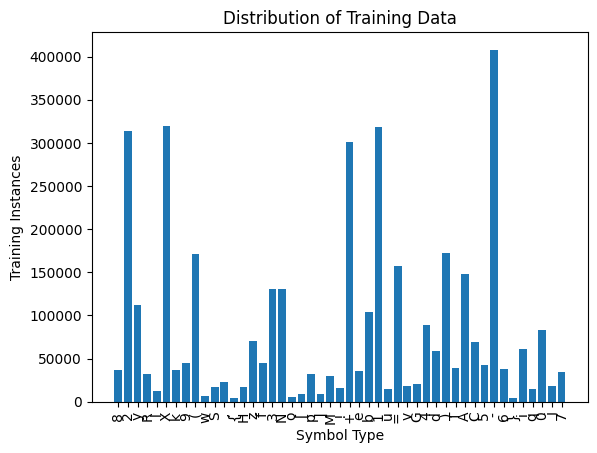

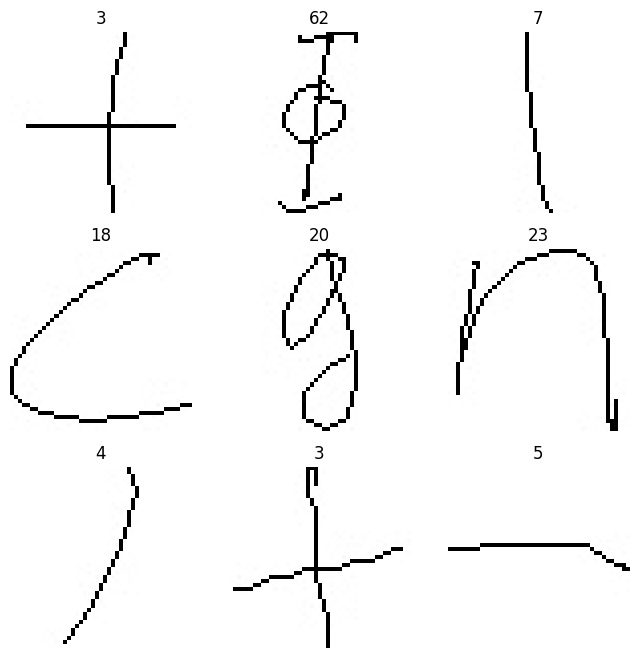

In [8]:
images, labels = next(iter(train_loader))
print(f"There are {len(os.listdir(DATA_PATH))} classes!")


classes = [sym for sym in os.listdir(DATA_PATH) if len(sym) == 1];
counts = [len(os.listdir(DATA_PATH + symbol)) for symbol in classes if len(symbol) == 1];
plt.bar(classes, counts);
plt.xlabel("Symbol Type");
plt.ylabel("Training Instances");
plt.title("Distribution of Training Data");
plt.xticks(rotation=90);

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx] #Images have shape [1, 45, 45] -> [channels, height, width]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# Training the Neural Network

### 1. Loss Function
- Using ```torch.nn.CrossEntropyLoss```

### 2. Optimization
- Using PyTorch builtin ```torch.optim.Adam``` optimizer

### 3. Training Loop:
    1. The model will be trained over 15 epochs.
    2. At each epoch, the model will do a forward pass of the images in the training dataset, and update the weights
    3. Then, the model will test against the validation set. When validation loss plateaus, the training will stop early.
        * Each epoch takes 15-30 minutes with the current optimizations; validation loss plateaus at ~epoch 11
#### Sources:
* https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html
* https://www.geeksforgeeks.org/machine-learning/training-neural-networks-with-validation-using-pytorch/

In [ ]:
CHECKPOINT_PATH = ".pth"
MODEL_PATH = "model.pth"
MIN_VALID_LOSS = 0.005 #Minimum necessary tolerance to keep training, otherwise ends training to avoid overfitting.
NUM_EPOCHS = 15 #Maximum number of epochs, early stopping will stop before then...
NUM_CLASSES = len(dataset.classes)

def trainNN(model, optimizer, loss_function, train_loader, val_loader):
    # Initialize
    history = {
        'train_loss': [],
        'train_acc': [],
        
        'val_acc': [],
        'val_loss': [],
        
        'epoch_time': [],
    }

    # Load relevant objects onto GPU (see performance tuning guide)
    model.to(DEVICE)
    print(f"Training with {DEVICE}")
    
    train_start = time()
    for epoch in range(NUM_EPOCHS):
        epoch_start = time()

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # ============== TRAINING ==============
        for images, labels in train_loader:
            # load to device
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            # optimizer.zero_grad() -> replace with iteration (see performance tuning guide)
            for param in model.parameters():
                param.grad = None
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1) #Get output with highest score
            correct += (predicted == labels).sum().item() #Count number of correct guesses
            total += labels.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total

        # ============== VALIDATION ==============
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad(): #Disable gradient calculation (see performance tuning guide)
            for images, labels in val_loader:
                # load to device
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                
                outputs = model(images)
                loss = loss_function(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total


        # ============== DATA CHECKPOINT ==============
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["epoch_time"].append(time() - epoch_start)

        checkpoint = {
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "history": history,
        }
        torch.save(checkpoint, f"epoch{epoch+1}_" + CHECKPOINT_PATH)
        
        print(f"\t- Epoch {epoch + 1}: {history['epoch_time'][epoch] / 60:.2f} minutes")
        print(f"\t\t* Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} ")
        print(f"\t\t* Validation Loss: {val_loss:.4f}, Validation Acc: {100 * val_acc:.4f} ")

        if history['val_loss'][epoch - 1] - val_loss < MIN_VALID_LOSS :
            print(f"Validation testing did not improve a sufficient amount! stopping training early.")
            break
        
    print(f"Training complete in {(time() - train_start) / 60 / 60:.2f} hours")
    torch.save(model.state_dict(), MODEL_PATH)
    return model, history

Execute training loop, saving checkpoints at each point.

In [ ]:
model = NeuralNetwork().to(DEVICE)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
model, history = trainNN(model, optimizer, loss_function, train_loader, val_loader)